# batch analysis of DNA-MERFISH for Aire DNA

by Pu Zheng

2021.10.01


# Load basic functions

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

36408


# 0. fov parameters

In [31]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA',
             'save_folder':r'I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA',
             'experiment_type': 'DNA',
             'num_threads': 25,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':250,
                     'max_num_seeds': None,
                     'spot_seeding_th': 600,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             'ref_id': 0, # special for this experiment
             }


In [19]:
_overwrite_image = False
fov_ids = np.arange(0,1)
_fov_id = 0
# create fov class
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          )
# 5. Process Protein images
fov.parallel=False
fov.protein_ref_id = 0
fov._process_image_to_spots('protein', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=True,
                            _fit_spots=False,
                            _overwrite_drift=False, _overwrite_image=_overwrite_image,
                            _overwrite_spot=False,
                            _verbose=True)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_000.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'protein_ref_im'] in 6.612s.
+ loading correction from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_000.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from sav

In [20]:
from scipy import ndimage
from skimage import exposure
from skimage import morphology

#aire_im = protein_ims[0]

# Adaptive Equalization
#aire_adapteq_im = exposure.equalize_adapthist(aire_im, clip_limit=0.03)

def generate_analysis_mask(image, gaussian_size=6., snr_th=3):
    from scipy import ndimage
    # gaussian blur this image to ignore internal feature
    seg_im = ndimage.gaussian_filter(image.copy(), gaussian_size)
    seg_im = seg_im / io_tools.load.find_image_background(seg_im)
    mask = seg_im > snr_th
    return mask.astype(np.bool)

#aire_mask = generate_analysis_mask(aire_im)

#dialate_size = 2
#dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

In [ ]:
visual_tools.imshow_mark_3d_v2([aire_im, aire_mask, dialated_mask])

In [59]:
_overwrite_image = False
fov_ids = np.arange(37,40)
#_fov_id = 0
# bad fov 3, 28, 36
for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    # 5. Process Protein images
    fov.parallel=False
    fov.protein_ref_id = 0
    fov._process_image_to_spots('protein', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=True,
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)

    # generate the dialated mask
    # 2.0: create a seed mask from protein image Aire
    with h5py.File(fov.save_filename, "r", libver='latest') as _f:
        _grp = _f['protein']
        protein_ims = _grp['ims'][:]
        #protein_ids = _grp['ids'][:]
    aire_im = protein_ims[0]
    aire_mask = generate_analysis_mask(aire_im, snr_th=2.5)
    dialate_size = 5
    dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

    _overwrite_image = False
    _overwrite_spot = False
    # 2. Process image into candidate spots
    fov.parallel=True
    fov.combo_ref_id = 0
    fov._process_image_to_spots('combo', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=False, 
                                _fit_spots=True,
                                _fit_in_mask=True,
                                _fitting_args={'seed_mask':dialated_mask},
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=_overwrite_spot,
                                _verbose=True)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_037.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'protein_ref_im'] in 5.948s.
+ loading correction from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_037.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from sav

++ base attributes loaded:['combo_ref_im', 'dapi_im', 'protein_ref_im'] in 8.953s.
+ loading correction from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5
++ base attributes loaded:[] in 0.001s.
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_039.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'combo_ref_im', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'dapi_im', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', '

In [1]:
# 2.0: create a seed mask from combo image Aire
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][12:14]
    combo_ids = _grp['ids'][12:14]


NameError: name 'h5py' is not defined

In [49]:
combo_ids

array([13, 14])

<IPython.core.display.Javascript object>


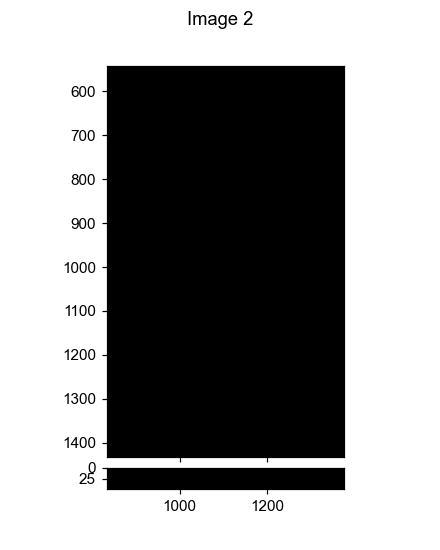

In [50]:
visual_tools.imshow_mark_3d_v2(combo_ims)

<IPython.core.display.Javascript object>


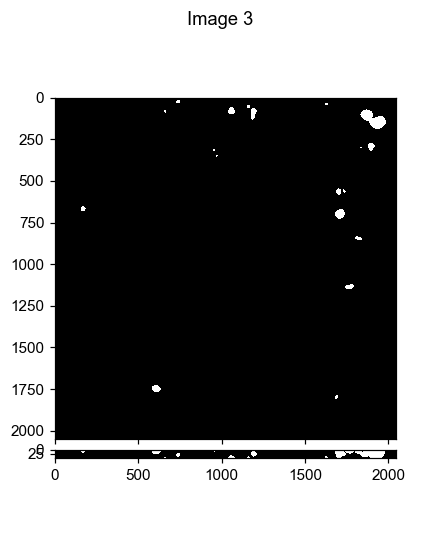

In [13]:
visual_tools.imshow_mark_3d_v2([aire_im, aire_mask, dialated_mask])

In [23]:
_overwrite_image = False
_overwrite_spot = False
# 2. Process image into candidate spots
fov.parallel=True
fov.combo_ref_id = 0
fov._process_image_to_spots('combo', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=False, 
                            _fit_spots=True,
                            _fit_in_mask=True,
                            _fitting_args={'seed_mask':dialated_mask},
                            _overwrite_drift=False, _overwrite_image=_overwrite_image,
                            _overwrite_spot=_overwrite_spot,
                            _verbose=True)


-- No folder selected, allow processing all 26 folders
-- checking combo, region:[1 2] in 0.004s.
-- checking combo, region:[3 4] in 0.003s.
-- checking combo, region:[5 6] in 0.003s.
-- checking combo, region:[7 8] in 0.003s.
-- checking combo, region:[ 9 10] in 0.003s.
-- checking combo, region:[11 12] in 0.003s.
-- checking combo, region:[13 14] in 0.003s.
-- checking combo, region:[15 16] in 0.003s.
-- checking combo, region:[17 18] in 0.003s.
-- checking combo, region:[19 20] in 0.003s.
-- checking combo, region:[21 22] in 0.003s.
-- checking combo, region:[23 24] in 0.003s.
-- checking combo, region:[25 26] in 0.003s.
-- checking combo, region:[27 28] in 0.003s.
-- checking combo, region:[29 30] in 0.003s.
-- checking combo, region:[31 32] in 0.003s.
-- checking combo, region:[33 34] in 0.003s.
-- checking combo, region:[35 36] in 0.003s.
-- checking combo, region:[37 38] in 0.003s.
-- checking combo, region:[39 40] in 0.003s.
-- checking combo, region:[41 42] in 0.003s.
-- check

In [33]:
fov._load_from_file('combo', _overwrite=True)

+ loading combo from file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_003.hdf5
++ finish loading combo in 0.009s. 


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1630: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


<IPython.core.display.Javascript object>


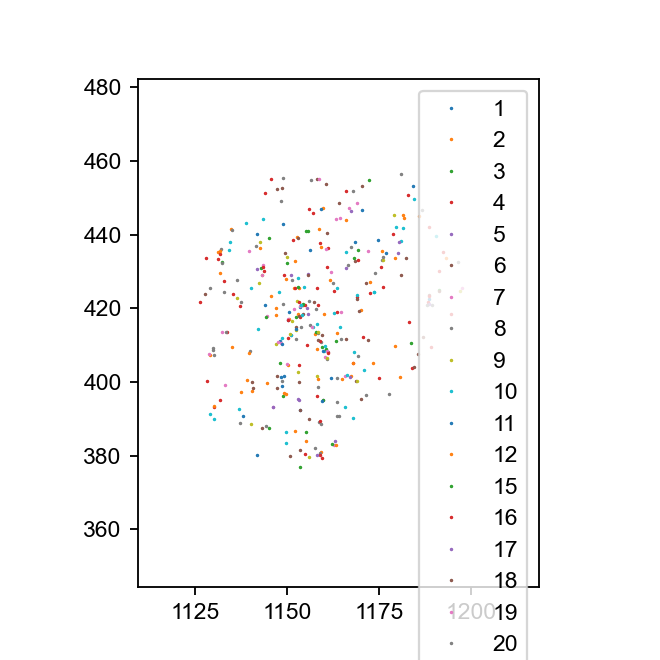

In [34]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
for _id, _spots in zip(fov.combo_ids, fov.combo_spots_list):
    if len(_spots) > 0:
        _sel_spots = _spots[(_spots[:,1] > 25) * (_spots[:,1] <= 35)]
        
        ax.plot(_sel_spots[:,2], _sel_spots[:,3], '.', markersize=1, label=f'{_id}')

ax.set_aspect('equal', 'box')
ax.legend()
plt.show()


In [27]:
# search pairs
zxys_list = [_spots[:,1:4]*fov.shared_parameters['distance_zxy'] for _spots in fov.combo_spots_list]

In [14]:


for _fov_id in fov_ids:
    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )
    # 2. Process image into candidate spots
    fov.combo_ref_id = 0
    fov._process_image_to_spots('combo', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=False, 
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)

    # 4. load dapi image
    dapi_im = fov._load_dapi_image(_dapi_id=0)

    # 5. Process Protein images
    fov.parallel=False
    fov.protein_ref_id = 0
    fov._process_image_to_spots('protein', 
                                _load_common_reference=True, _load_with_multiple=False,
                                _save_images=True,
                                _warp_images=True,
                                _fit_spots=False,
                                _overwrite_drift=False, _overwrite_image=_overwrite_image,
                                _overwrite_spot=False,
                                _verbose=True)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loadi

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_011.dax  in 24.018s
-- removing hot pixels for channels:['561'] in 10.692s
-- correct Z-shifts for channels:['561'] in 8.531s
-- illumination correction for channels: 561, in 3.612s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 48.001s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_011.hdf5
++ base attributes saved:['combo_ref_im'] in 8.597s.
-- checking combo, region:[1 2] in 0.006s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.005s.
us

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_012.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_012.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_012.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522

-- removing hot pixels for channels:['561'] in 10.147s
-- correct Z-shifts for channels:['561'] in 8.285s
-- illumination correction for channels: 561, in 3.160s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 47.999s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_013.hdf5
++ base attributes saved:['combo_ref_im'] in 8.117s.
-- checking combo, region:[1 2] in 0.004s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.004s.
used_channels: ['750', '647', '561']
-- checking c

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_014.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'co

-- illumination correction for channels: 561, in 2.646s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 38.472s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_014.hdf5
++ base attributes saved:['protein_ref_im'] in 7.865s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['

++ base attributes saved:['combo_ref_im'] in 8.104s.
-- checking combo, region:[1 2] in 0.005s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[15 16] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[17 18] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[19 20] in 0.005s.
used_channels: ['750', '647', '561']
-- checking combo, region:[21 22] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[23 24] in 0.004s.
u

	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_016.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', '

++ processed protein ids: [1 2] + batch process image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax for channels:['647', '488']
- loading protein info from file:Conv_zscan_016.hdf5 in 0.613s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_016.hdf5
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_016.dax  in 21.912s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 42.538s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 31.094s
-- bleedthrough correction for channels: ['750', '647'] in 11.635s
-- illumination correction for channels: 750, 647, 488, 561, in 12.403s
-- apply bead_drift calculate for channel: 561
-- start a

 49 50] , finish in 406.48s.
-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_017.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_017.dax  in 10.677s
-- removing hot pixels for channels:['405'] in 13.130s
-- correct Z-shifts for channels:['405'] in 8.995s
-- illumination correction for channels: 405, in 3.841s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 37.814s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_017.hdf5
++ base attributes saved:['dapi_im'] in 7.940s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_

-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5
--- combo attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
save type: protein"
-- saving protein to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_018.hdf5
--- protein attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_018.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_018.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x20

-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.561s
-- update drift of H25P1\Conv_zscan_018.dax into file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\drift\Conv_zscan_018_current_cor.pkl
in 372.80s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ loa

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax  in 11.713s
-- removing hot pixels for channels:['405'] in 12.981s
-- correct Z-shifts for channels:['405'] in 7.459s
-- illumination correction for channels: 405, in 2.693s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 35.861s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_019.hdf5
++ base attributes saved:['dapi_im'] in 7.885s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_019.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_W

-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_020.dax  in 6.910s
-- removing hot pixels for channels:['561'] in 10.092s
-- correct Z-shifts for channels:['561'] in 8.006s
-- illumination correction for channels: 561, in 2.957s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 28.851s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_020.hdf5
++ base attributes saved:['combo_ref_im'] in 7.991s.
-- checking combo, region:[1 2] in 0.004s.
used_ch

dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 

-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_021.dax  in 16.525s
-- removing hot pixels for channels:['561'] in 9.145s
-- correct Z-shifts for channels:['561'] in 7.272s
-- illumination correction for channels: 561, in 2.673s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 36.845s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_021.hdf5
++ base attributes saved:['protein_ref_im'] in 7.832s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used

	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_023.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'co

-- illumination correction for channels: 561, in 2.928s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 23.895s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_023.hdf5
++ base attributes saved:['protein_ref_im'] in 7.650s.
used_channels: ['750', '647', '561', '405']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['750', '647', '561']
used_channels: ['

-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_024.hdf5
++ base attributes saved:['combo_ref_im'] in 7.558s.
-- checking combo, region:[1 2] in 0.004s.
used_channels: ['750', '647', '561', '405']
-- checking combo, region:[3 4] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[5 6] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[7 8] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[ 9 10] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[11 12] in 0.004s.
used_channels: ['750', '647', '561']
-- checking combo, region:[13 14] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[15 16] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[17 18] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[19 20] in 0.003s.
used_channels: ['750', '647', '561']
-- checking combo, region:[21

	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_025.dax: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5.
* create savefile: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel', 'dapi_channel_index', 'data_folder', 'debug', 'drift', 'drift_channel', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'parallel', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', '

- loading protein info from file:Conv_zscan_025.hdf5 in 0.596s.
-- ['647', '488'] images are required to process, [] images are loaded from save file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_025.hdf5
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_025.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H25P1\Conv_zscan_025.dax  in 8.661s
-- removing hot pixels for channels:['750', '647', '488', '561'] in 41.958s
-- correct Z-shifts for channels:['750', '647', '488', '561'] in 30.642s
-- bleedthrough correction for channels: ['750', '647'] in 10.546s
-- illumination correction for channels: 750, 647, 488, 561, in 11.693s
-- apply bead_drift calculate for channel: 561
-- start aligning given source image to given reference image.
--- align image 0 in 8.050s.
--- align image 1 in 7.978s.
--- align image 2 in 8.123s.
--- drifts for crops:[0 1 2] pass th

 49 50] , finish in 387.96s.
-- choose dapi images from folder: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_026.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_026.dax  in 7.437s
-- removing hot pixels for channels:['405'] in 12.026s
-- correct Z-shifts for channels:['405'] in 8.881s
-- illumination correction for channels: 405, in 4.045s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.358s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_026.hdf5
++ base attributes saved:['dapi_im'] in 8.079s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5

-- saving 750_647_bleed profile to save_file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5.
dict_keys(['combo', 'protein'])
save type: combo"
-- saving combo to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5
--- combo attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
save type: protein"
-- saving protein to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_027.hdf5
--- protein attributes updated:['ids', 'channels', 'ims', 'spots', 'raw_spots', 'drifts', 'flags'] in 0.002s.
-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_027.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_027.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x20

-- updated ims for id:[2, 1], drifts for id:[2, 1] in 3.868s
-- update drift of H25P1\Conv_zscan_027.dax into file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\drift\Conv_zscan_027_current_cor.pkl
in 369.30s.
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 172
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ loa

-- No folder selected, allow processing all 26 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax
-- loading illumination correction profile from file:
	 561 illumination_correction_561_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210927-Thymus_WT_0522_CTP-10-DNA\H0C1\Conv_zscan_029.dax  in 5.571s
-- removing hot pixels for channels:['561'] in 9.166s
-- correct Z-shifts for channels:['561'] in 7.119s
-- illumination correction for channels: 561, in 2.703s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 25.440s
-- saving fov_info to file: I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA\Conv_zscan_029.hdf5
++ base attributes saved:['combo_ref_im'] in 8.069s.
-- checking combo, region:[1 2] in 0.004s.
used_cha

In [9]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_ids = _grp['ids'][:]

In [10]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['protein']
    protein_ims = _grp['ims'][:]
    protein_ids = _grp['ids'][:]

<IPython.core.display.Javascript object>


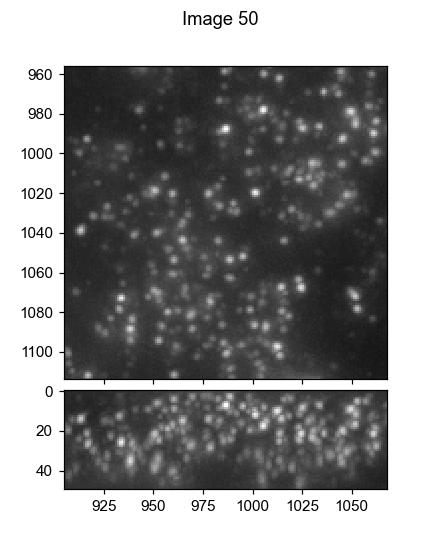

In [11]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([protein_ims[0]]+list(combo_ims))
